Jacobo Casado de Gracia - Visión por computador
En este notebook se va a realizar la práctica 1 de Visión por Computador.

Antes de comenzar, se adjuntan los métodos de la práctica 0 puesto a que, en ciertas partes del código se usan para facilitar el almacenamiento y representación de las imágenes.

In [ ]:
# Jacobo Casado de Gracia. Práctica 0 de Visión por Computador.
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import uuid
from scipy.stats import norm

def pintaImagen(imagen):
  figura = plt.figure(uuid.uuid4(), figsize = (15,15))
  plt.imshow(imagen, cmap='gray')

def leeImagen(filename, flagColor):
  img = cv.imread(filename, flagColor)
  pintaImagen(img)
  return img

def pintaI(im):
  minimo = np.min(im)
  maximo = np.max(im)
  longitud = maximo - minimo
  # Pasamos al intervalo [0,1] la imagen.
  im = (im - minimo) / longitud
  im = im * 255
  pintaImagen(im)


# EJERCICIO 1. Implementación de la máscara discreta 1D de la función Gaussiana, la derivada primera y segunda de la Gaussiana.

* La función implementada para crear cada una de estas tres máscaras (se crearán tres funciones cuyo valor de retorno es la máscara en cuestión) recibe como parámetros, o bien la longitud de la máscara, o bien el sigma (varianza) del valor de la gaussiana discretizada.

* Primero, se va a crear un método que recibe una longitud de vector y devuelve un vector de números enteros de esa misma longitud, cuyo centro es el número 0 y comienza desde los números negativos hasta los positivos.
Es decir, si llamamos a generaVector(5), la salida devolverá un vector: [-2,-1,0,1,2]

In [ ]:
# Jacobo Casado de Gracia. Práctica 1 Visión por Computador. Año 2021
# Ejercicio 1. Implementación de la máscara gaussiana de 1D.
# Esta máscara recibe el valor de sigma o bien la longitud de la máscara.
# Dependiendo del parámetro que reciba, si bien es sigma se calculará la longitud de la máscara y si se da la máscara se procederá a calcular sigma.
import cv2 as cv
import math
import matplotlib.pyplot as plt

def generaVector(longitud):
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    vector = np.zeros(longitud)
    # Llenamos el vector con los valores de x que se van a introducir en las funciones que nos discretizarán la gaussiana, la primera derivada 
    # y la segunda derivada para obtener la máscara final.
    vector[0] = valor_min
    for i in range (1, longitud):
        vector[i] = vector[i-1] + 1
    return vector


# A continuación, definiremos las funciones de la gaussiana, y su primera y segunda derivada.

Éstas son funciones matemáticas que reciben un valor de x, así como un valor de la desviación típica de dicha distribución, sigma, que en cuyo caso y dependiendo de éste último, representa la "escala" del kernel, y devuelven el valor de y la distribución correspondiente (gaussiana, primera derivada o segunda).

Lo primero que vamos a hacer es incidir en el aspecto de que la máscara 2D de la Gaussiana (y sus derivadas) es separable en dos máscaras 1D, las cuales son, además, iguales.

La propiedad de la igualdad no ocurre para todas las máscaras, pero sí se cumple para las máscaras de discretización de la gaussiana.

Es decir, sabemos que podemos transformar todo kernel 2D en dos kernel 1D pero no todos los kernel 2D se descomponen en kernel 1D iguales
(visto en la página 36 de las diapositivas de teoría); en este caso sí se puede ya que la función de la gaussiana 2D se puede separar como el PRODUCTO de las funciones en x e y de esta misma.

La fórmula de la distribución usada para la gaussiana se ha visto en las diapositivas de teoría, en el apartado "Gaussian Kernel as a Filter" de esta asignatura (página 35 de las diapositivas de teoría), y las derivadas se han conseguido en un proceso derivativo simple.

Recordar que, al ser igual la máscara 1D en ambas dimensiones, x e y, sus derivadas también serán iguales, ya que en una derivaremos en x, y en la otra derivaremos en y, obteniendo, de nuevo, la misma máscara.

Por tanto, y antes de comenzar con los cálculos de la máscara discreta, se procede a adjuntar estas tres funciones matemáticas descritas anteriormente, que nos serán herramientas útiles.


In [ ]:
def gaussiana(sigma, valor):
    return  math.exp(-0.5 * ((valor**2)/(sigma*sigma)))

def primera_derivada(sigma, valor):
    return (-1) * (valor / (sigma**2)) * math.exp((-1) * ((valor**2) / (2 * sigma**2)))

def segunda_derivada(sigma, valor):
    return ((-(valor)/sigma**2) * primera_derivada(sigma, valor)) + ((-1/sigma**2) * gaussiana(sigma, valor))

# Discretización de la gaussiana 1D (y sus derivadas)
# En realidad, la diferencia entre discretizar la Gaussiana y sus derivadas será la función que aplicaremos a nuestro vector muestreado para obtener un valor diferente del Kernel dependiendo de si queremos la Gaussiana o alguna de sus derivadas.
Sabiendo ya de antemano que el kernel de la Gaussianna es separable, calcularemos un kernel 1D DISCRETO.
## Ojo, discreto.
Eso significa que, o bien necesitamos saber la longitud de la máscara donde vamos a discretizar la Gaussiana, o bien el sigma (o varianza) de esta gaussiana.
## Debemos de tener en cuenta que:
1. El kernel final que obtengamos debe de sumar 1 si sumamos todos sus elementos (la Gaussiana como distribución de probabilidad, cubre un 100% desde -infinito a +infinito, o bien el área de la Gaussiana procedente de integrar sobre x e y da 1).

Por tanto, muestrearemos la señal en un vector de valores de X, y hacemos que sumen 1.

2. Sabemos que la longitud en píxeles de la máscara es, aproximadamente, y haciendo cuentas:

$longitud = 2 * parteentera[2.5 * sigma] + 1$

### Podemos apreciar que la longitud en píxeles de la máscara siempre será IMPAR.

3. De -2.5 * desviación típica a 2.5 * desviación típica aproximadamente hay un 98% de área (en la distribución Gaussiana)
4. La longitud en píxeles de la máscara siempre va a dar impar = 2*(parte entera de 2.5*sigma) + 1

## Por tanto, el método que haremos para discretizar la Gaussiana sera uno que, o bien reciba un Gamma prefijado, o bien reciba una longitud de máscara (a la cual, y por la razón de la ecuación que hemos visto justo antes, le corresponde un sigma asociado a esta longitud).

Eso será lo primero que haremos en el método.

# SIGUIENTE PASO: MUESTREO DEL VECTOR.

## Lo siguiente que vamos a hacer es generar un vector de la misma longitud de la máscara a crear y evaluaremos los puntos en X que correspondan tal que, si n es el tamaño de la máscara, el vector tendrá esta construcción:

$[-(n-1)/2, ... , 0 , ... , (n-1)/2]$

## De tal manera que, si la longitud de la máscara es, por ejemplo, 5, el vector que obtendríamos sería:
$[-2, -1, 0, 1, 2]$

## Queremos este vector (generado con la función generaVector especificada al principio de la práctica 1)
### porque evaluaremos los puntos de este vector con la función gaussiana que hemos también especificado anteriormente, para obtener el valor de la gaussiana en estos puntos.

### Una vez obtenido el valor de la gaussiana en estos puntos, nos aseguramos de que la sumatoria de todos los valores de este vector sumen 1, es decir, NORMALIZAMOS el vector para que cumpla las propiedades que cumple la distribución gaussiana.

# El vector resultante de todas estas operaciones sería la gaussiana discretizada y muestreada en un intervalo dado de longitud N (o sigma) dado y especificado previamente por el usuario, EN FORMA DE VECTOR 1D.



In [ ]:
def mascaraGaussiana1D(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = (longitud - 1) / 5

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)

    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = gaussiana(sigma, mascara_gaussiana[i])
    
    mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    #print('Gaussiana: ', mascara_gaussiana)
    return(mascara_gaussiana)



## Realizamos exactamente lo mismo para crear la primera y segunda derivada, con una sutil diferencia:
### En vez de evaluar nuestro vector muestreado con la función de la Gaussiana, simplemente lo evaluamos usando la derivada primera y segunda de ésta.
### También debemos de normalizar el vector para que conforme aumente el tamaño de máscara, se produzca el mismo efecto de derivada, multiplicando por sigma cada uno de los valores de la máscara (de este tamaño, al multiplicar por este constante, los valores no se ven afectados por el aumento de sigma)

In [ ]:

def mascaraGaussiana1D_derivada(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = ((longitud - 1) / 5)

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)
    
    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = primera_derivada(sigma, mascara_gaussiana[i])
        mascara_gaussiana[i] = mascara_gaussiana[i] * sigma
    # print('Primera derivada: ', mascara_gaussiana)
   # mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    return(mascara_gaussiana)


## Hacemos lo mismo con la segunda derivada y su fórmula correspondiente.

In [ ]:

def mascaraGaussiana1D_derivada_segunda(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = ((longitud - 1) / 5)

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)

    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = segunda_derivada(sigma, mascara_gaussiana[i])
        mascara_gaussiana[i] = mascara_gaussiana[i] * sigma
    
        # mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    # print('Segunda derivada: ', mascara_gaussiana)
    return(mascara_gaussiana)
    
      

# Representación, comparación e inferencia
## A continuación, representaremos en ejes cartesianos las máscaras obtenidas en forma de función 1D y comparemos con la función nativa de OpenCV que genera estos Kernels, llamada $OpenCV.getDerivKernels()$.
### Haremos esta comparación con los Kernels de tamaño 5, 7 y 9 respectivamente.

# Representación de los Kernels de tamaño 5, 7 y 9 de la GAUSSIANA
Representaremos en dos gráficos de manera separada ambos kernel y, posteriormente, compararemos los resultados.
## getDerivKernels(0,1,5)[0] nos devuelve un kernel Gaussiano de tamaño 5.
## getDerivKernels(0,1,5)[1] nos devuelve un kernel de primera derivada de la Gaussiana de tamaño 5.

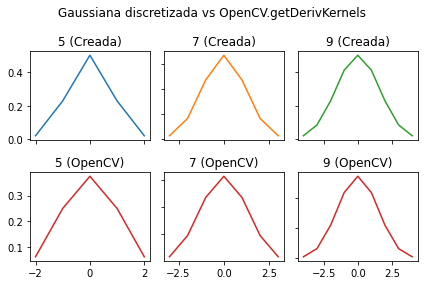

In [ ]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D(None,5)
mascara1D_size7 = mascaraGaussiana1D(None,7)
mascara1D_size9 = mascaraGaussiana1D(None,9)
openCV1D_size5 = cv.getDerivKernels(0,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(0,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(0,1,9,normalize=1)


x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada vs OpenCV.getDerivKernels')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## Como podemos comprobar, la máscara obtenida discretizando la gaussiana y la que crea openCV, para tamaños de máscara de 7 y 9, es prácticamente la misma; en tamaño 5 no se da tanto el parecido ya que la gaussiana que OpenCV crea cuando se llama a la función getDerivKernels es una gaussiana creada aproximada con la binomial, por tanto, es muy difícil que el sigma obtenido por esta aproximación, en un tamaño de máscara tan bajo, sea el mismo que discretizando la gaussiana. Conforme aumentamos el tamaño de máscara, ambas representaciones convergen en parecido.


# Representación de los kernels de la primera derivada de la Gaussiana
## (Los creados en este apartado y los de OpenCV)
### Para representar la primera derivada, tenemos que especificar con un 1 el primer parámetro en la función CV.getDerivKernels(); de esta manera, estamos derivando en X. 
### Posteriormente, obtendremos la máscara 1D en X (ya derivada) referenciándonos con [0] al objeto que devuelve esta función.

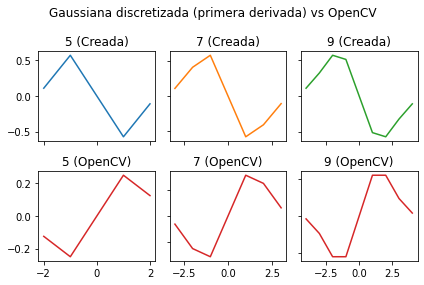

In [ ]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D_derivada(None,5)
mascara1D_size7 = mascaraGaussiana1D_derivada(None,7)
mascara1D_size9 = mascaraGaussiana1D_derivada(None,9)
openCV1D_size5 = cv.getDerivKernels(1,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(1,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(1,1,9,normalize=1)

x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada (primera derivada) vs OpenCV')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## En este caso podemos apreciar que las máscaras de primera derivada que openCV crea son la máscara simétrica resultante a la que hemos creado nosotros discretizando la gaussiana.
### Esto ocurre debido a que los Kernel que openCV devuelve con esta función están ya invertidos con la intención de que se van a usar para convolucionar; ya sabemos que al convolucionar, se necesita dar la vuelta a la máscara. Por tanto, openCV devuelve el Kernel ya dado la vuelta para la convolución.

# Hacemos lo mismo con la segunda derivada.
## Simplemente hemos de introducir un 2 en el primer parámetro de la función getDerivKernels; de esta manera, cuando hagamos getDerivKernels[0] accederemos a la máscara 1D en X, que será la segunda derivada.

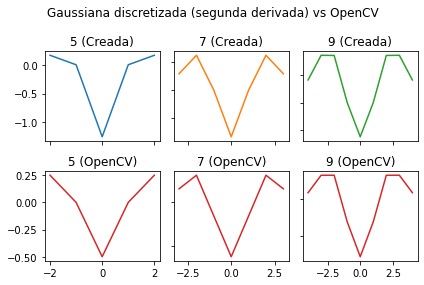

In [ ]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D_derivada_segunda(None,5)
mascara1D_size7 = mascaraGaussiana1D_derivada_segunda(None,7)
mascara1D_size9 = mascaraGaussiana1D_derivada_segunda(None,9)
openCV1D_size5 = cv.getDerivKernels(2,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(2,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(2,1,9,normalize=1)

x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada (segunda derivada) vs OpenCV')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## Como podemos ver, son bastante parecidos los resultados y podemos asumir que la máscara de la gaussiana está relativamente bien hecha; cabe destacar que cuanto más aumentamos el tamaño de máscara, mayor parecido tienen los gráficos.
## Probaremos el uso de las máscaras creadas en este apartado más tarde con una imagen.

# Ejercicio 2. Calcular las máscaras discretas 1D de longitud 5 y 7 de alisamiento y de derivada de primer orden usando la aproximación binomial de la Gaussiana.
## Primero nos dedicaremos a hacer las máscaras de alisamiento. Para hacer estas máscaras, haremos la pirámide de pascal de 7 pisos (ya que la máscara máxima que vamos a realizar es de longitud 7), y cada fila de la pirámide es, realmente, un kernel de la binomial.
## Una vez que tengamos la pirámide de pascal, tomaremos el kernel de la binomial del tamaño que queramos y lo normalizamos para obtener la máscara de alisamiento, ya que debe de cumplir la propiedad de que la suma de todos sus elementos sea 1, para que el kernel ni sume ni reste información a la imagen original.
### A continuación se adjunta el código del método que recibe la longitud de la máscara y calcula el kernel de la binomial aproximada a la Gaussiana.

In [ ]:
def mascaraAlisamientoAproximada(longitud):
    # Primero, almacenamos la pirámide binomial pero de longitud 7 máximo porque nos hace falta como mucho eso.
    piramide_pascal = np.array([[1], [1, 1], [1,2,1], [1,3,3,1], [1,4,6,4,1], [1,5,10,10,5,1], [1,6,15,20,15,6,1]])
    # Simplemente las normalizamos para obtener la máscara de alisamiento, ya que debe de cumplir la propiedad de que la suma de todos sus elementos de el valor de 0 para que no
    # sume ni reste información a la imagen original.
    mascara = np.array(piramide_pascal[longitud - 1])
    return (mascara / sum(mascara))

# Para la derivada, sin embargo, haremos un proceso un poco más largo.
## Seguiremos utilizando la pirámide de Pascal, pero en este caso, si queremos una máscara de longitud $M$ utilizaremos la máscara de longitud 3 de la derivada de la Gaussiana (que sabemos que es, por definición y visto en las clases de teoría, $[-1,0,1]$, y convolucionaremos una máscara de longitud $M - 2$ con esta máscara derivada para obtener la máscara de longitud $M$)
### Ligera anotación: en este ejercicio, como todavía no se ha pedido implementar la convolución de dos vectores, se ha usado Numpy.Convolve para realizarla. NO OBSTANTE, a partir del ejercicio siguiente se ha implementado una convolución manual que podría sustituir, si se desease, a esta convolución; es simplemente cambiar la llamada correspondiente.


In [ ]:
# A continuación, haremos la máscara de derivada de primer orden usando la función del apartado A que calcula la primera derivada y la entrada es nuestra gaussiana (pero en este caso, aproximada)
# con la binomial)
def primeraDerivadaAproximada(longitud):
    # Primero, almacenamos la pirámide binomial pero de longitud 7 máximo porque nos hace falta como mucho eso.
    piramide_pascal = np.array([[1], [1, 1], [1,2,1], [1,3,3,1], [1,4,6,4,1], [1,5,10,10,5,1], [1,6,15,20,15,6,1]])
    # Simplemente las normalizamos para obtener la máscara de alisamiento, ya que debe de cumplir la propiedad de que la suma de todos sus elementos de el valor de 0 para que no
    # sume ni reste información a la imagen original.
    mascara = np.array(piramide_pascal[longitud - 1 - 2])
    mascara = mascara / sum(mascara)

    mascara_derivada_long3 = [-1,0,1]

    # Ya se ha aplicado la máscara de alisamiento, ya que hemos aproximado a la gaussiana.
    # Lo que nos queda es convolucionar con el vector -1, 0, 1 para obtener la derivada.
    derivada = np.convolve(mascara, mascara_derivada_long3)
    return(derivada)

# Definidas ambas funciones, veremos los Kernel que obtenemos de llamar a estas funciones con tamaño de máscara de 5 y 7, y la máscara que OpenCV devuelve con la funcion OpenCV.getDerivKernels(0,1,9).
# Posteriormente, veremos la relación entre los vectores de salida de estas dos funciones diferentes, y la posible relación que hay entre ambas funciones.

/var/folders/qb/lpsh6qq14v79cvlswml7vv3h0000gn/T/ipykernel_979/1810207959.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  piramide_pascal = np.array([[1], [1, 1], [1,2,1], [1,3,3,1], [1,4,6,4,1], [1,5,10,10,5,1], [1,6,15,20,15,6,1]])
/var/folders/qb/lpsh6qq14v79cvlswml7vv3h0000gn/T/ipykernel_979/3990289187.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  piramide_pascal = np.array([[1], [1, 1], [1,2,1], [1,3,3,1], [1,4,6,4,1], [1,5,10,10,5,1], [1,6,15,20,15,6,1]])


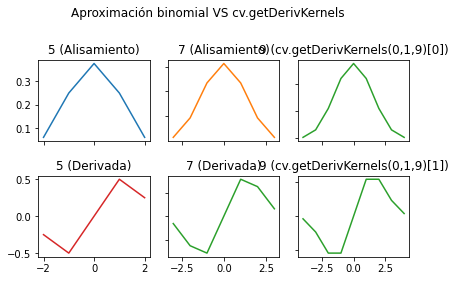

In [ ]:
x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

mascara1D_size5 = mascaraAlisamientoAproximada(5)
mascara1D_size7 = mascaraAlisamientoAproximada(7)

mascara1D_size5_derivada = primeraDerivadaAproximada(5)
mascara1D_size7_derivada = primeraDerivadaAproximada(7)

mascara1d_size5_openCV = (cv.getDerivKernels(0,1,5, normalize=1))[0]
mascara1d_size7_openCV = (cv.getDerivKernels(0,1,7, normalize=1))[0]
mascara1d_size5_derivada_openCV = (cv.getDerivKernels(1,1,5,normalize=1))[0]
mascara1d_size7_derivada_openCV = (cv.getDerivKernels(1,1,7, normalize=1))[0]
mascara1d_size9_derivada_openCV_1 = (cv.getDerivKernels(0,1,9,normalize=1))[0]
mascara1d_size9_derivada_openCV_2 = (cv.getDerivKernels(0,1,9, normalize=1))[1]


fig, axs = plt.subplots(2,3)
fig.suptitle('Aproximación binomial VS cv.getDerivKernels')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Alisamiento)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Alisamiento)')
axs[1, 0].plot(x_5, mascara1D_size5_derivada, 'tab:red')
axs[1, 0].set_title('5 (Derivada)')
axs[1, 1].plot(x_7, mascara1D_size7_derivada, 'tab:green')
axs[1, 1].set_title('7 (Derivada)')
axs[0, 2].plot(x_9, mascara1d_size9_derivada_openCV_1, 'tab:green')
axs[0, 2].set_title('9 (cv.getDerivKernels(0,1,9)[0])')
axs[1, 2].plot(x_9, mascara1d_size9_derivada_openCV_2, 'tab:green')
axs[1, 2].set_title('9 (cv.getDerivKernels(0,1,9)[1])')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout(pad = 1.5)

plt.show()


## Ya se ha comentado anteriormente, en otro apartado, pero se recalca que lo que se puede extraer de esta información es que openCV extrae los kernel gaussianos a partir de la APROXIMACIÓN BINOMIAL de la gaussiana, es decir, usando la misma técnica que se ha usado en este ejercicio.

Text(0.5, 1.0, 'Imagen Derivada en Y')

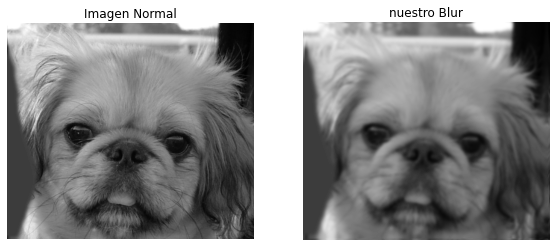

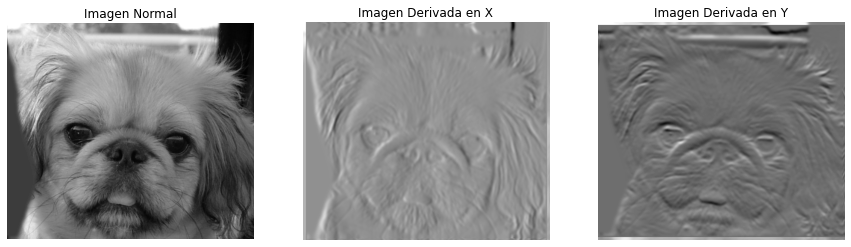

In [ ]:
# Ejercicio 3. 

# ESTA FUNCIÓN NO HACE FALTA, PERO LA HE DEJADO AUN ASÍ.
# NO SE HA USADO EN NINGÚN EJERCICIO.
# Primero, he implementado la función que separa el kernel 2D (suponiendo la propiedad de separabilidad de éste, no nos ponemos a comprobarlo),
# en dos kernel 1d (para aplicar uno sobre la imagen, y aplicar el otro sobre la imagen traspuesta; de esta manera, obtendríamos el mismo resultado)
# que si convolucionásemos la imagen con ese mismo kernel pero antes de ser separado.

# Descompongo el Kernel con una función de numpy llamada SVD, que hace la descomposición en valores singulares de la máscara.
# En clases de teoría vimos que todo kernel 2D real M siempre admite una descomposición en valores singulares.

def separar(kernel2d):
    U, S, V = np.linalg.svd(kernel2d)
    h1 = U[:,0] * np.sqrt(S[0])
    h2 = V[0] * np.sqrt(S[0])
    return h1,h2

# A continuación, implemento la función de convolución de un vector 1d con otro vector 1d.
# Antes de llamar a esta función, realizaremos un reajuste con la imagen para escalarla en el rango de 0 a 1, ya que OpenCV las lee y las codifica de 0 a 255.

def convolucion1D(a, k):
  # Le damos la vuelta a la mascara
  #k = np.flip(k)

  longitud_mascara = len(k)
  # Calculamos el semilado
  semilado = int(np.floor(longitud_mascara / 2))

  # El vector convolucionado aumentara en 2 veces el semilado
  #ceros = np.zeros(int(semilado), dtype=np.int)
  #a = np.insert(a, ceros, 0)
  #a = np.append(a, ceros)

  # El vector v almacenará el vector convolucionado
  v = np.array(a)
  
  centro_mascara = int(semilado)

  for i in range (semilado, len(a) - semilado):
    valor = 0.0
    for j in range(len(k)):
      valor = valor + k[j] * a[i + semilado - j]

    v[i] = valor


  return v

def convolucionar(kernel1d_1, kernel1d_2, imagen2d):
  
    # Primero, separamos el Kernel 2d suponiendo la propiedad de separabilidad de éste
    # Obtenemos el kernel que vamos a aplicar por filas y columnas.        
    # kernel_filas = separar(kernel2d)[0]
    # kernel_columnas = separar(kernel2d)[1]

    # Obtenemos el semilado del kernel; lo que haremos con este semilado es añadir a la imagen un reflejo de esta en los bordes del tamaño del semilado,
    # de manera que SIEMPRE, tras realizar este ajuste, la máscara se ajuste a cada fila y columna de la imagen. 
    semilado_kernel = (int)((np.size(kernel1d_1) - 1) / 2)

    # Añadimos a la imagen píxeles con razón del semilado, pero OJO: sólo a la izquierda y derecha!!!
    # Luego rotaremos la imagen (después de convolucionar) y volveremos a añadir píxeles con razón del semilado, una vez rotada
    # Con "rotar" me refiero a trasponer la matriz que representa la imagen.
    imagen2d = cv.copyMakeBorder(imagen2d, 0, 0, semilado_kernel, semilado_kernel, cv.BORDER_REFLECT_101)
    imagen2d = imagen2d/255

    imagenConvolucionada = np.array(imagen2d)

    # Una vez añadidos los píxeles, aplicamos la convolución por cada una de las filas de la imagen:
    for i in range(imagen2d.shape[0]):
        imagenConvolucionada[i] = np.array(convolucion1D(imagen2d[i], kernel1d_1))

    # Ahora, hacemos la traspuesta de la matriz imagen, añadimos a la imagen píxeles con razón del semilado a izquierda y derecha,
    # aplicaremos la convolución y volvemos a hacer la traspuesta para obtener la imagen convolucionada con el kernel finalmente.
    imagenConvolucionada = np.transpose(imagenConvolucionada)
    imagenConvolucionada = cv.copyMakeBorder(imagenConvolucionada, 0, 0, semilado_kernel, semilado_kernel, cv.BORDER_REFLECT_101)
  
    imagenAuxiliar = np.array(imagenConvolucionada)
    
    for i in range(imagenConvolucionada.shape[0]):
        imagenConvolucionada[i] = np.array(convolucion1D(imagenAuxiliar[i], kernel1d_2))
        
    imagenConvolucionada = np.transpose(imagenConvolucionada)

    imagenConvolucionada = imagenConvolucionada * 255

    # Una vez eso, podemos mostrar la imagen convolucionada.
    # Si hacemos la convolución correctamente y usamos como kernel la Gaussiana, deberíamos de poder obtener la imagen con "blur"
    # (que, obviamente, dependera de gamma, y de la longitud de la máscara, por tanto, que apliquemos.) 
    return (imagenConvolucionada)


fig = plt.figure(figsize=(15, 15))
rows = 1
columns = 3

imagenNormal = cv.imread('./imagenes/dog.bmp', 0)
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(imagenNormal, cmap='gray')
plt.axis('off')
plt.title("Imagen Normal")
# Generamos la máscara gaussiana usando las funciones del apartado A.
kernel_gaussiano = mascaraGaussiana1D(2,None)
imagenBlur = convolucionar(kernel_gaussiano ,kernel_gaussiano, imagenNormal)
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(imagenBlur, cmap='gray')
plt.axis('off')
plt.title("nuestro Blur")

fig = plt.figure(figsize=(15, 15))
rows = 1
columns = 3
# showing image
fig.add_subplot(rows, columns, 1)
plt.imshow(imagenNormal, cmap='gray')
plt.axis('off')
plt.title("Imagen Normal")
kernel_derivada = mascaraGaussiana1D_derivada(2,None)
imagenDerivadaX = convolucionar(kernel_derivada, kernel_gaussiano, imagenNormal)
# showing image
fig.add_subplot(rows, columns, 2)
plt.imshow(imagenDerivadaX, cmap='gray')
plt.axis('off')
plt.title("Imagen Derivada en X")
imagenDerivadaY = convolucionar(kernel_gaussiano, kernel_derivada, imagenNormal)
# showing image
fig.add_subplot(rows, columns, 3)
plt.imshow(imagenDerivadaY, cmap='gray')
plt.axis('off')
plt.title("Imagen Derivada en Y")


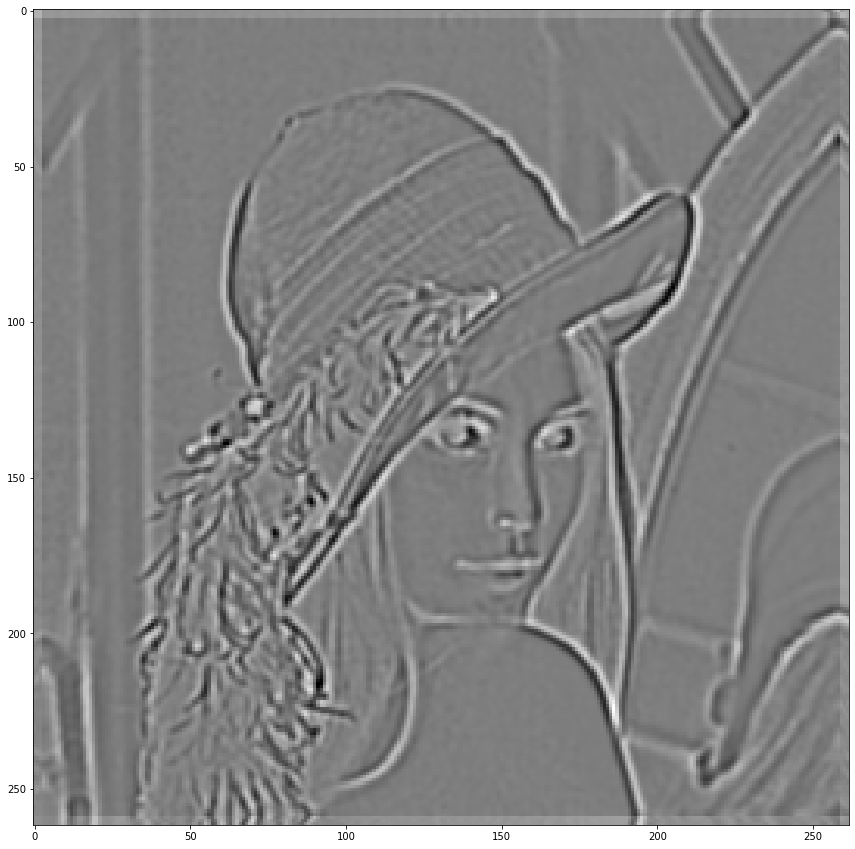

In [79]:
# Ejercicio 4. Para calcular la máscara normalizada de la Laplaciana de una Gaussiana, tenemos que:
# 1. convolucionar por filas con la derivada segunda de la Gaussiana y, luego, por columnas, la convolución con la Gaussiana.
# 2. convolucionar por filas con la Gaussiana y, luego, por columnas, la convolución con la segunda derivada de la Gaussiana.
# 3. Sumar lo obtenido anteriormente.
# 4. Multiplicar el resultado anterior por sigma^2 (para normalizarlo)s

# Recordar que la laplaciana de la Gaussiana no es separable DIRECTAMENTE en dos kernel 1D.
# Sabemos que van a hacer falta dos máscaras 1D para obtener la máscara de la laplaciana, porque, como la máscara 2d gaussiana es separable y
# sus máscaras 1D en X es la misma que la máscara 1D en Y.

def calcularLaplaciana(imagen2d, sigma):

    derivadaSegunda = cv.getDerivKernels(2,1,7)[0]
    # derivadaSegunda = mascaraGaussiana1D_derivada_segunda(None, 7)

    primeraConvolucion = convolucionar(derivadaSegunda, mascaraGaussiana1D(None, 7), imagen2d)
    segundaConvolucion = convolucionar(mascaraGaussiana1D(None, 7), derivadaSegunda, imagen2d)
    imagenFinal = (primeraConvolucion + segundaConvolucion) * (sigma**2)
    return imagenFinal

imagen2d = cv.imread('./imagenes/lena.jpg', 0)
pintaI(calcularLaplaciana(imagen2d, 1))


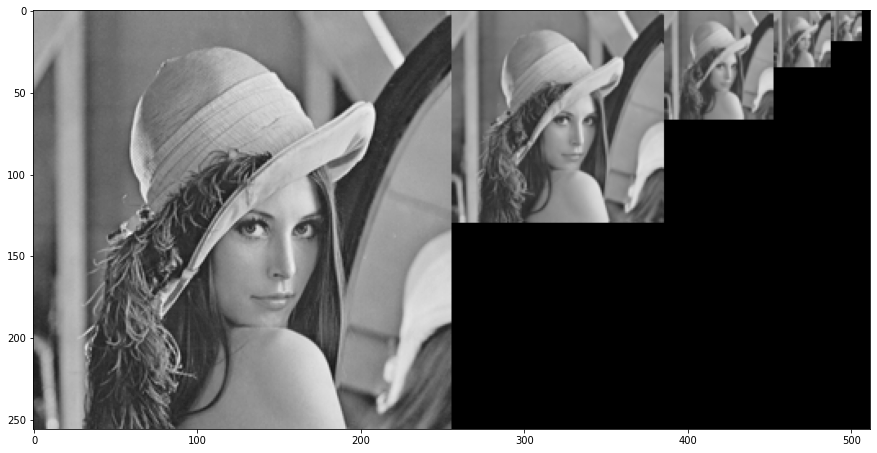

In [91]:
def subsamplear(imagen):
    imagenSubsampleada = imagen
    imagenSubsampleada = np.delete(imagenSubsampleada, range(0,imagenSubsampleada.shape[0], 2), axis=0)
    imagenSubsampleada = np.delete(imagenSubsampleada, range(0,imagenSubsampleada.shape[1], 2), axis=1)

    return imagenSubsampleada

def filtroBlur(imagen, sigma):
    kernel_gaussiano = mascaraGaussiana1D(sigma,None)
    return (convolucionar(kernel_gaussiano ,kernel_gaussiano, imagen))

def piramideGaussiana(imagen):
    # Creamos la piramide donde caben todas las imágenes (las vamos a añadir en horizontal)
    piramide = np.zeros([imagen.shape[0],imagen.shape[1] * 2],dtype=np.float64)
    # Insertamos la primera imagen
    piramide[0:piramide.shape[0] , 0:imagen.shape[1]] = imagen[0:imagen.shape[0] , 0:imagen.shape[1]]

    # El proceso ahora es repetitivo. Blureamos la imagen (empezamos con sigma 1, y duplicamos el sigma en cada iteración)
    # Luego la subsampleamos (reducimos a la mitad su tamaño) y la añadimos a la matriz.
    sigma = 1
    imagen2 = filtroBlur(imagen, sigma)
    imagen2 = subsamplear(imagen2)

    ## Añadimos la imagen 2 a la pirámide que hemos creado.
    piramide[0: imagen2.shape[0] , imagen.shape[1]: imagen.shape[1] + imagen2.shape[1] ] = imagen2[0:imagen2.shape[0] , 0:imagen2.shape[1]]

    # Lo mismo con la imagen 3 y 4: duplicamos el sigma, le aplicamos el filtro y subsampleamos.
    #sigma = 2 * sigma
    imagen3 = filtroBlur(imagen2,sigma)
    imagen3 = subsamplear(imagen3)
    # Añadimos a la pirámide la 3º imagen.
    piramide[0: imagen3.shape[0] , imagen.shape[1] + imagen2.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] ] = imagen3[0:imagen3.shape[0] , 0:imagen3.shape[1] ]

    # Hacemos lo mismo con la cuarta imagen.
    #sigma = 2 * sigma
    imagen4 = filtroBlur(imagen3,sigma)
    imagen4 = subsamplear(imagen4)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen4.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] ] = imagen4[0:imagen4.shape[0] , 0:imagen4.shape[1] ]
    
    # Incluimos la quinta imagen de la pirámide (que sería el cuarto piso, el máximo que nos piden, ya que el piso 0 es la imagen original)
    #sigma = 2 * sigma
    imagen5 = filtroBlur(imagen4,sigma)
    imagen5 = subsamplear(imagen5)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen5.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] + imagen5.shape[1] ] = imagen5[0:imagen5.shape[0] , 0:imagen5.shape[1] ]

    return piramide

imagen2d = cv.imread('./imagenes/lena.jpg', 0)
piramide = piramideGaussiana(imagen2d)
pintaI(piramide)

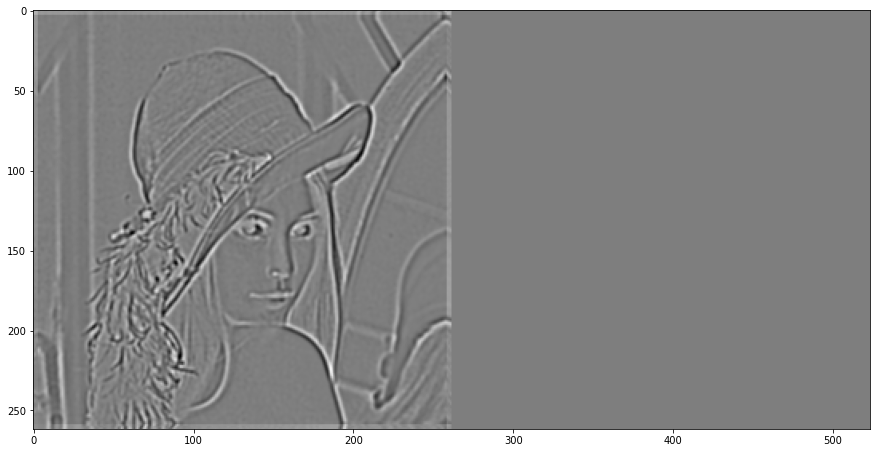

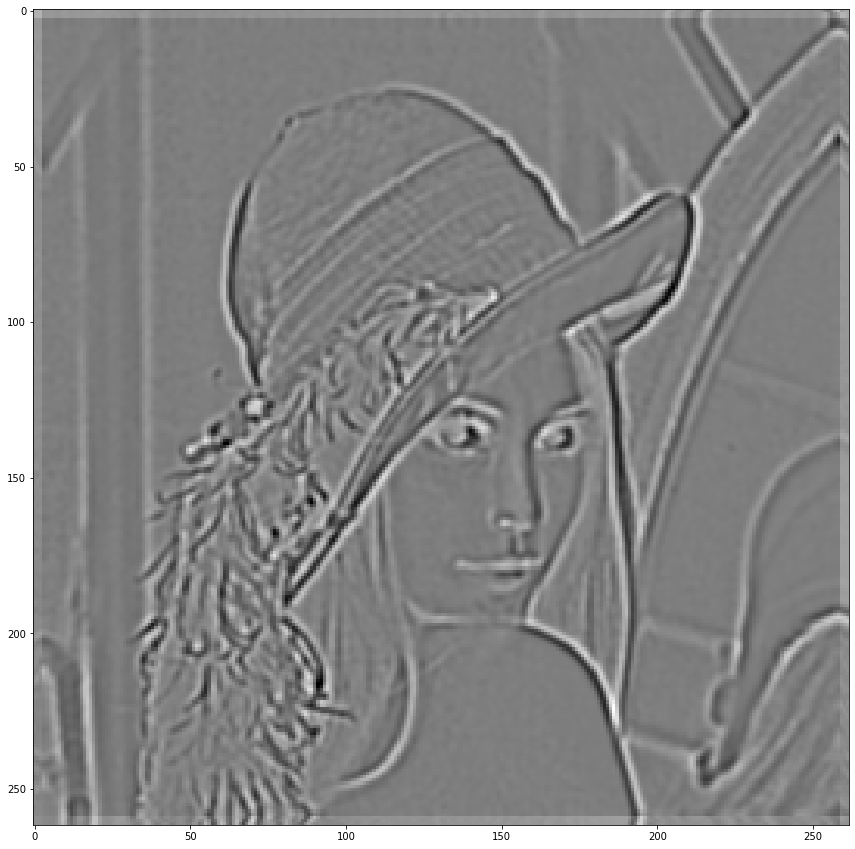

In [90]:
def piramideLaplaciana(imagen):
    sigma = 1
    # Creamos la piramide donde caben todas las imágenes (las vamos a añadir en horizontal)
    laplaciana1 = calcularLaplaciana(imagen, sigma)
    piramide = np.ones([laplaciana1.shape[0],laplaciana1.shape[1] * 2],dtype=np.float64)
    # Insertamos la laplaciana de la imagen.
    
    piramide[0:laplaciana1.shape[0] , 0:laplaciana1.shape[1]] = laplaciana1[0:laplaciana1.shape[0] , 0:laplaciana1.shape[1]]

    return piramide

imagen2d = cv.imread('./imagenes/lena.jpg', 0)
piramide = piramideLaplaciana(imagen2d)
pintaI(piramide)
imagen = calcularLaplaciana(imagen2d, 1)
pintaI(imagen)
    